# RespiCoV sequencing analysis

Reads fastq file(s) from nanopore sequencing output using [RespiCoV](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264855) primers

## Initialization and configuration

In [129]:
from Bio.Seq import Seq
from Bio import SeqIO
import os
import gzip
import pandas as pd

fastQBaseDir = "../20221204_2344_MN41817_FAV39017_1bf37150/fastq_pass/"

pd.options.display.max_rows = 100
pd.options.display.min_rows = 50

primers = list(SeqIO.parse("RespiCovPrimers.fasta", "fasta"))
print("Read %i primers" % (len(primers)))

Read 113 primers


## Utility functions

In [174]:
# Generate all exact matches from the primers set (including reverse complements)
# from a given fastQ file
def getPrimerMatches(subdir):
    fastQDir = os.path.join(fastQBaseDir, subdir)
    for fastQFile in filter(lambda f: f.endswith(".fastq.gz"), os.listdir(fastQDir)):
        with gzip.open(os.path.join(fastQDir, fastQFile), "rt") as handle:
            for record in list(SeqIO.parse(handle, "fastq")):
                hits = []
                for primer in primers:
                    i = record.seq.find(primer.seq)
                    while (i >= 0):
                        hits.append((primer,i,i+len(primer.seq)-1))
                        i = record.seq.find(primer.seq, i+1)
                    rc = primer.seq.reverse_complement()
                    i = record.seq.find(rc)
                    while (i >= 0):
                        hits.append((primer,i+len(primer.seq)-1,i))
                        i = record.seq.find(rc, i+1)
                yield (record, hits)    
                
def getAllPrimerMatches():
    for dir in sorted(os.listdir(fastQBaseDir)):
        if dir.startswith("barcode"):
            for (r,h) in getPrimerMatches(dir):
                yield (dir, r, h)

## How many primers are found in each read?

In [132]:
from collections import Counter

readsPerPrimerCount = Counter()
readTotal = 0
for (record, hits) in getPrimerMatches("barcode07"):
    readTotal += 1
    readsPerPrimerCount[len(hits)] += 1

table = pd.DataFrame.from_dict(readsPerPrimerCount, orient="index", columns=["Reads"])
table.index.name = "Primer Count"
table.sort_index(inplace=True)
table["%"] = table["Reads"].apply(lambda r: round(r / readTotal * 100, ndigits=2))
table

,Reads,%
Primer Count,,
0,347,42.89
1,301,37.21
2,143,17.68
3,13,1.61
4,2,0.25
5,2,0.25
6,1,0.12


## How often is each primer seen?

In [142]:
hitsPerPrimer = dict()
for p in primers:
    hitsPerPrimer[p.description] = [0,0]

hitsTotal = 0
for (record, hits) in getPrimerMatches("barcode07"):
    hitsTotal += len(hits)
    for (primer, s, e) in hits:
        hitsPerPrimer[primer.description][0 if s < e else 1] += 1

def addPercent (entry):
    (primer, [fwd,rev]) = entry
    return (primer, fwd, rev, round((fwd+rev) / hitsTotal * 100, ndigits=2))

data = map(addPercent, filter(lambda p:p[1]!=[0,0], hitsPerPrimer.items()))
table = pd.DataFrame(data, columns=["Primer","Fwd hits", "Rev hits", "%"])
table.set_index("Primer", inplace=True)
table.sort_values("%", ascending=False, inplace=True)
table

,Fwd hits,Rev hits,%
Primer,,,
Influenza A virus 2,10,18,4.31
SARS coronavirus 1/2 3,17,11,4.31
MERS coronavirus 1,4,18,3.38
Human parechovirus 2,14,6,3.08
Respirovirus 2,10,8,2.77
SARS coronavirus 1/2 2,11,6,2.62
Human parechovirus 1,7,8,2.31
Influenza A virus 7,7,8,2.31
Measles virus 2,6,8,2.15


## Which primers are never seen?

In [151]:
from collections import Counter

unseen = set(map(lambda p:p.description, primers))

for (dir, record, hits) in getAllPrimerMatches():
    for (primer, s, e) in hits:
        unseen.discard(primer.description)

pd.DataFrame(unseen, columns=["Primer"])

,Primer
0,Human respiratory syncytial virus 1
1,Influenza B virus 5
2,Influenza A virus 22
3,Influenza A virus 20


## What's the distribution of read lengths and primer positions?

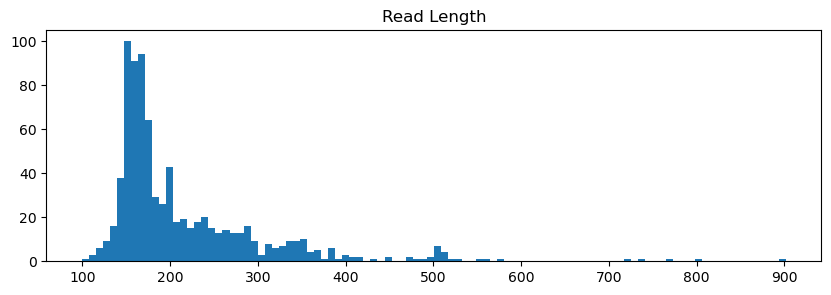

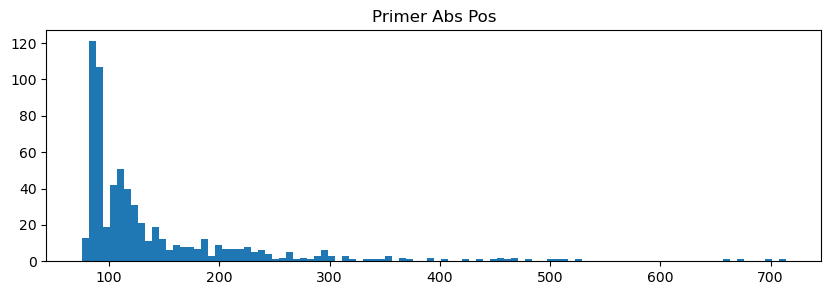

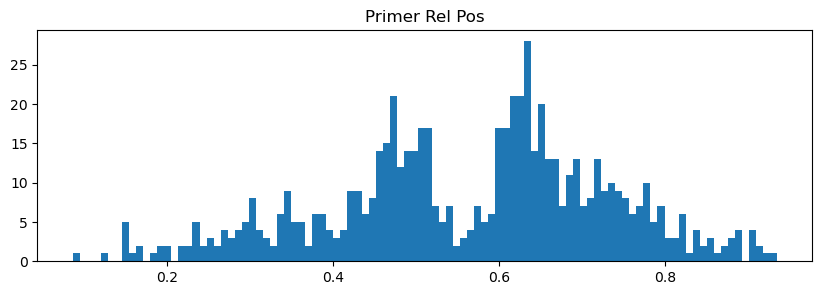

In [139]:
lengths=[]
paPos=[]
prPos=[]

for (record, hits) in getPrimerMatches("barcode07"):
    lengths.append(len(record.seq))
    paPos += map(lambda pse: max(pse[1],pse[2]), hits)
    prPos += map(lambda pse: (pse[1]+pse[2])/2/len(record.seq), hits)

pd.DataFrame({'Read Length': lengths}).hist(bins=100, figsize=(10,3), grid=False)
pd.DataFrame({'Primer Abs Pos': paPos}).hist(bins=100, figsize=(10,3), grid=False)
pd.DataFrame({'Primer Rel Pos': prPos}).hist(bins=100, figsize=(10,3), grid=False);

## Find possible primer pairs

In [175]:
for (dir, record, hits) in getAllPrimerMatches():
    for (primer,s,e) in hits:
            if s<e:
                pd = primer.description[:primer.description.rindex(' ')]
                for (p2,s2,e2) in hits:
                    if e2<s2 and p2.description.startswith(pd):
                        span = e2 - e - 1 if s2 > s else s - s2 - 1
                        if span > 200:
                            print("%s %s: %d %s @(%d,%d) - %s @(%d,%d)" % \
                                  (dir, record.id, span, primer.description, s, e, p2.description, s2, e2))

barcode03 ced0bdea-73ef-440d-9440-a13702a18140: 310 Rhinovirus/Enterovirus 1 @(63,83) - Rhinovirus/Enterovirus 3 @(414,394)
barcode03 5aec69e7-8ec7-4b39-b3f3-c0edcad3eace: 345 Rhinovirus/Enterovirus 1 @(70,90) - Rhinovirus/Enterovirus 3 @(456,436)
barcode03 946bd1d5-9c37-4979-9965-1b5c75e3ca73: 348 Rhinovirus/Enterovirus 3 @(69,89) - Rhinovirus/Enterovirus 1 @(458,438)
barcode04 5da9f858-2489-40d2-9209-4fb032000568: 309 Human adenovirus 2 @(67,87) - Human adenovirus 6 @(418,397)
barcode06 0a3c042d-8166-447b-983e-85a43e393fcf: 279 Influenza A virus 7 @(105,125) - Influenza A virus 2 @(423,405)
barcode06 8245fd91-474d-4cad-866e-2a24aebd2217: 348 Rhinovirus/Enterovirus 1 @(75,95) - Rhinovirus/Enterovirus 3 @(464,444)
barcode07 6082e1b1-de83-41be-8e44-a5834f145c04: 350 Rhinovirus/Enterovirus 1 @(68,88) - Rhinovirus/Enterovirus 3 @(459,439)
barcode07 c63d9144-0d93-4620-ba79-2a7bf050e813: 340 Rhinovirus/Enterovirus 1 @(67,87) - Rhinovirus/Enterovirus 3 @(448,428)
barcode07 4280c73a-c4c3-4038

# Debugging

In [162]:
# Dump all the matches for debugging purposes (verbose)
matches = 0
records = 0
for (record, hits) in getPrimerMatches("barcode07"):
    records += 1
    if len(hits)>0:
        matches += 1
        print("Read %s len %i matches:" % (record.id,len(record.seq)))
        for (primer,s,e) in hits:
            print("   %i-%i: %s%s" % (s, e, primer.description, " (rev)" if e<s else ""))
print("Found %i matches in %i reads" % (matches, records))

Read f4603494-90b7-4ea0-baaf-ac702ca3f693 len 140 matches:
   66-87: Herpes simplex virus 1
Read 9abe5abf-79bd-4de0-a9ba-25dcbb5dc7cf len 147 matches:
   102-82: Legionelle pneumophila 1 (rev)
Read ce9293f9-8cde-4ca0-8477-198a988631fc len 269 matches:
   67-88: Human coronavirus NL63 2
Read b88654ff-37dc-4890-945e-46e3baa2cad0 len 149 matches:
   70-90: Influenza A virus 4
Read 7e8f0133-7b5e-4768-83e4-883d28eeb644 len 227 matches:
   176-156: Influenza A virus 16 (rev)
Read e0a40248-b682-480c-8309-ade2ca3cde1b len 154 matches:
   103-83: Legionelle pneumophila 1 (rev)
Read fe8ceb42-48b8-4f3b-830c-a08edd1ed94d len 154 matches:
   105-83: Chlamydophila pneumoniae 2 (rev)
   64-87: Mycoplasma pneumoniae 1
Read 670e4763-8f5e-4379-b892-a2ea00805c02 len 164 matches:
   74-97: Mycoplasma pneumoniae 1
Read 0a21a79d-3120-4c52-b1ec-5176c6b37cd7 len 202 matches:
   149-129: SARS coronavirus 1/2 3 (rev)
Read 79ad8ccb-c531-44c7-aa07-8ae4fc59c804 len 195 matches:
   145-126: Influenza A virus 5 (rev